<font size=6>目录</font>
* [Preparation](#1)
* [Descriptive statistical analysis](#2)
    * [Input data](#2.1)
    * [Time plot of weekly log return ${y_t}$](#2.2)
    * [Descriptive statistics](#2.3)
    * [MACM plots of weekly log return $y_t$](#2.4)
    * [PACF of weekly log return $y_t$ and absolute weekly log return $|y_t|$](#2.5)
* [VLDAR](#3)
    * [BIC](#3.1)
    * [Model estimation](#3.2)
    * [Portmanteau tests](#3.3)
    * [MACM plots of residuals](#3.4)
    * [MACM plots of absolute residuals](#3.5)
* [Recursive forecasting](#4)
    * [Prediction functions](#4.1)
    * [Forecasts](#4.2)
    * [Backtests](#4.3)

## Preparation<a id="1"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm


from main.SQMLE_VLDAR_BCD import SQMLE_VLDAR_BCD
from main.LDAR import LDAR
from main.CCCGARCH2 import mgarch
from main.MACM import MACM


## Descriptive statistical analysis<a id="2"></a>

### Input data <a id="2.1"></a>

In [2]:
df=pd.read_csv('SP500sector.csv',index_col=0)
df.index=pd.to_datetime(df.index,format = '%Y/%m/%d')
df.columns=['C D','C S', 'H C']

In [3]:
yt=100*(np.log(df).diff(1))#log difference
yt=yt.dropna()
yt=yt-yt.mean()# central
T,N=yt.shape

### Time plot of weekly log return $y_t$<a id="2.2"></a>

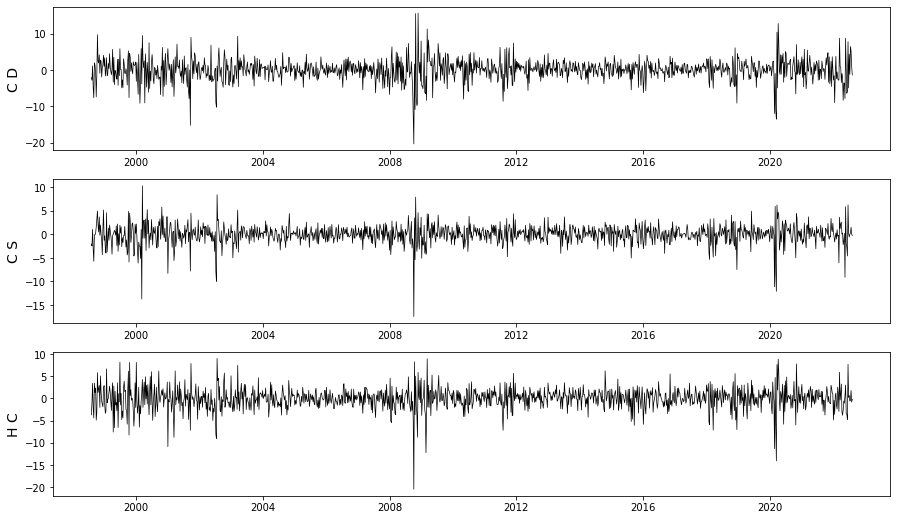

In [4]:
x=yt.index
fig=plt.figure(num=2,figsize=(15,3*N))

for i in range(N):
    exec(f"ax{i+1}=fig.add_subplot({N}1{i+1})")
    exec(f"ax{i+1}.set_ylabel(yt.columns[{i}],fontsize=14)")
    exec(f"ax{i+1}.plot(x,yt.values[:,i],color='k',lw=0.7)")

plt.savefig('timeplot_logreturn.pdf')
plt.show()

### Descriptive statistics<a id="2.3"></a>

In [5]:
yt.describe().round(3)

,C D,C S,H C
count,1254.000,1254.000,1254.000
mean,0.000,-0.000,0.000
std,3.045,2.078,2.503
min,-20.330,-17.460,-20.488
25%,-1.437,-0.984,-1.232
50%,0.080,0.095,0.105
75%,1.692,1.140,1.357
max,15.616,10.318,9.028


In [6]:
print('skew:\n{} \n kurt:\n{}'.format(yt.skew(),yt.kurt()))

skew:
C D   -0.383615
C S   -1.175532
H C   -0.744700
dtype: float64 
 kurt:
C D    4.510255
C S    8.688615
H C    6.162340
dtype: float64


### MACM plots of $y_t$<a id="2.4"></a>

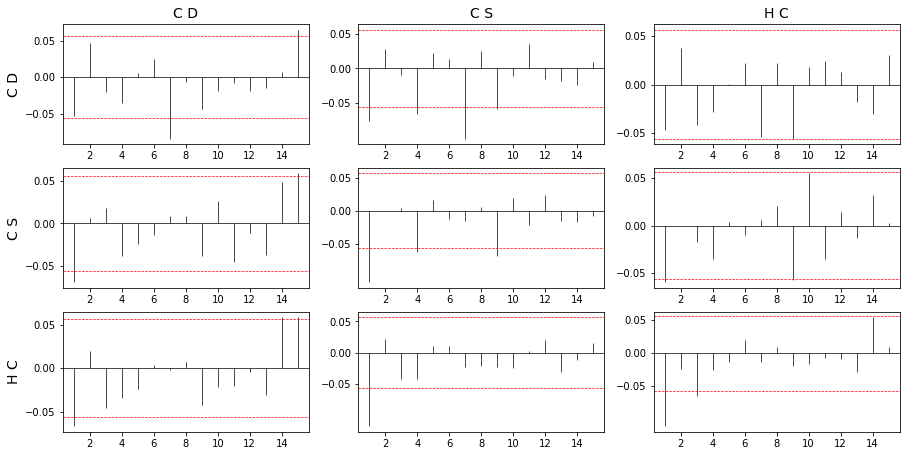

In [7]:
MACM_y=MACM(yt.values,15)

lag=16
T,N=np.shape(yt)
N=3
err_bound = 2 / np.sqrt(T)
xlabel_lags=np.arange(1,lag)
fig=plt.figure(num=4,figsize=(15,N*2.5))
k=1
for i in range(N):
    for j in range(N):
        
        exec(f"ax{k}=fig.add_subplot(33{i*N+j+1})")
        exec(f"ax{k}.vlines(xlabel_lags, [0], MACM_y[:,i,j] ,color='k',linewidth=0.7)")
        exec(f"ax{k}.axhline(0, color='k',linewidth=0.7)")

        exec(f"ax{k}.axhline(err_bound, color='r', linestyle='--',linewidth=0.7)")
        exec(f"ax{k}.axhline(-err_bound, color='r', linestyle='--',linewidth=0.7)")
        exec(f"ax{k}.set_yticks(np.linspace(-0.05,0.05,3))")
        k+=1
ax1.set_ylabel("C D",fontsize=14)
ax4.set_ylabel('C S',fontsize=14)
ax7.set_ylabel('H C',fontsize=14)

ax1.set_title("C D",fontsize=14)
ax2.set_title('C S',fontsize=14)
ax3.set_title('H C',fontsize=14)
plt.show()

###  PACF of weekly log return $y_t$ and absolute weekly log return $|y_t|$<a id="2.5"></a>

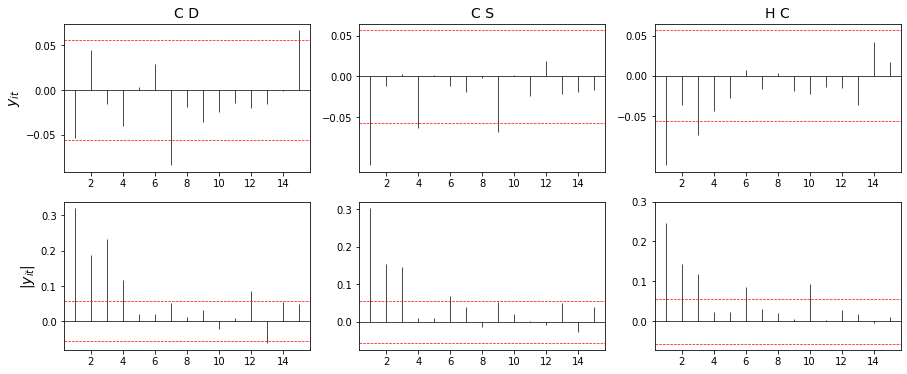

In [8]:
lag=16

T,N=np.shape(yt.values)


err_bound = 2 / np.sqrt(T)
from statsmodels.tsa import stattools
xlabel_lags=np.arange(1,lag)
fig=plt.figure(num=3,figsize=(15,N*2))
for i in range(N):
    exec(f"ax{i+1}=fig.add_subplot(2{N}{i+1})")
    exec(f"ax{i+1}.vlines(xlabel_lags, [0],stattools.pacf(yt.iloc[:,{i}])[1:lag] ,color='k',linewidth=0.7)")
    exec(f"ax{i+1}.axhline(0, color='k',linewidth=0.7)")
    exec(f"ax{i+1}.set_yticks(np.linspace(-0.05,0.05,3))")
    exec(f"ax{i+1}.axhline(err_bound, color='r', linestyle='--',linewidth=0.7)")
    exec(f"ax{i+1}.axhline(-err_bound, color='r', linestyle='--',linewidth=0.7)")
    
    exec(f"ax{i+1+N}=fig.add_subplot(2{N}{i+1+N})")
    exec(f"ax{i+1+N}.vlines(xlabel_lags, [0],stattools.pacf(yt.iloc[:,{i}].abs())[1:lag],color='k',linewidth=0.7 )")
    exec(f"ax{i+1+N}.axhline(0, color='k',linewidth=0.7)")
    
    exec(f"ax{i+1+N}.axhline(err_bound, color='r', linestyle='--',linewidth=0.7)")
    exec(f"ax{i+1+N}.axhline(-err_bound, color='r', linestyle='--',linewidth=0.7)")
    exec(f"ax{i+1+N}.set_yticks(np.linspace(0,0.3,4))")
ax1.set_ylabel("$y_{it}$",fontsize=14)
ax4.set_ylabel("$|y_{it}|$",fontsize=14)
ax1.set_title("C D",fontsize=14)
ax2.set_title("C S",fontsize=14)
ax3.set_title("H C",fontsize=14)
# ax{2}.set_ylabel('PACF')

plt.savefig('pacf_y_y_abs.pdf')
plt.show()

## VLDAR<a id="3"></a>

### BIC<a id="3.1"></a>

In [9]:
fit=SQMLE_VLDAR_BCD(yt.values)
fit.BIC(10) ## order selection using BIC given r_m=10

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [21:59<00:00, 131.96s/it]


((1, 3),
              1            2            3            4            5   \
 1   6830.203563  6746.273743  6704.556390  6735.261393  6769.498673   
 2   6880.857374  6802.652293  6757.981069  6788.245619  6823.018347   
 3   6934.013061  6857.718646  6816.088001  6846.896622  6881.187595   
 4   6989.940511  6915.233675  6873.263707  6904.236495  6938.259479   
 5   7044.199006  6969.897409  6927.676134  6958.195642  6991.933891   
 6   7107.583376  7033.349029  6990.588629  7020.918510  7055.245427   
 7   7164.887808  7090.982529  7050.961601  7081.050341  7115.850839   
 8   7222.961085  7149.099293  7109.507917  7139.460016  7174.295127   
 9   7278.822339  7207.924736  7169.263267  7199.642266  7233.908172   
 10  7332.177206  7263.071176  7224.239870  7255.143882  7289.339489   
 
              6            7            8            9            10  
 1   6824.265529  6887.132624  6940.754174  7010.252851  7310.523246  
 2   6875.860968  6941.078085  6998.375092  7065.533551

### Model estimation<a id="3.2"></a>

In [10]:
N=3;p=1;q=3 # selected order
lam=fit.fit(p,q,result_show=True) # model estimation using QMLE

   loc_ratio  var_ratio     cov_ratio  var_direct  lam_ratio
1   4.828345   5.691590  1.055345e-02    0.000020   5.691590
2   1.476424   0.009891  1.995529e-04    0.004688   1.415739
3   0.058662   0.000348  5.434232e-06    0.000107   0.057308
4   0.000913   0.000011  1.317485e-07    0.000003   0.000830
break for reach tol
detial each difference:
   loc_ratio  var_ratio     cov_ratio  var_direct  lam_ratio
1   4.828345   5.691590  1.055345e-02    0.000020   5.691590
2   1.476424   0.009891  1.995529e-04    0.004688   1.415739
3   0.058662   0.000348  5.434232e-06    0.000107   0.057308
4   0.000913   0.000011  1.317485e-07    0.000003   0.000830
time consume for each part:
t_loc     0.522649
t_var    11.266891
t_cov     0.130677
dtype: float64
loc:
[[ 0.00059841 -0.06788434 -0.01978378]
 [-0.00756987 -0.06784867 -0.01235586]
 [ 0.03443544 -0.06392903 -0.08023578]] 
 var:
[[0.9876269  0.15078208 0.13376525 0.03217143 0.13759397 0.14027243
  0.07060482 0.21698881 0.03878227 0.05300628]
 

In [11]:
A_D=fit.Asymptotic_deviation()['A_D'].round(3) ## standard errors of the QMLE
loc_AD_mat=A_D[:N**2*p].reshape((N,N*p),order='F')
var_AD_mat=A_D[N**2*p:N**2*(p+q)+N].reshape((N,N*q+1),order='F')
cov_AD=A_D[-N*(N-1)//2:]
cov_AD_mat=np.zeros((N,N))
cov_AD_mat[np.tril_indices(N,-1)]=cov_AD
cov_AD_mat+=cov_AD_mat.T
print("the ASD of location params:\n",loc_AD_mat,"\n",
     "the ASD of scale params:\n",var_AD_mat,"\n",
     "the ASD of correlation params:\n",cov_AD_mat)

the ASD of location params:
 [[0.041 0.059 0.047]
 [0.028 0.041 0.034]
 [0.034 0.05  0.042]] 
 the ASD of scale params:
 [[0.119 0.044 0.063 0.051 0.043 0.064 0.051 0.044 0.063 0.051]
 [0.099 0.035 0.051 0.042 0.033 0.052 0.041 0.034 0.053 0.043]
 [0.108 0.037 0.055 0.046 0.037 0.058 0.045 0.037 0.057 0.046]] 
 the ASD of correlation params:
 [[0.    0.026 0.024]
 [0.026 0.    0.025]
 [0.024 0.025 0.   ]]


### Portmanteau tests<a id="3.3"></a>

In [12]:
# Q(M) for M=6,9 and 12 
for i in [6,9,12]:
    exec(f"port_stat_{i},p_{i}=fit.portmanteau_test({i}).loc['stat_mix_abs'].round(3)")
    exec(f"print('When M={i}, the portmanteau test statistic is:', port_stat_{i}, 'and p_value is:',p_{i})")

When M=6, the portmanteau test statistic is: 89.914 and p_value is: 0.896
When M=9, the portmanteau test statistic is: 165.054 and p_value is: 0.419
When M=12, the portmanteau test statistic is: 219.277 and p_value is: 0.425


### MACM plots of residuals<a id="3.4"></a>

In [13]:
eta_ios=fit.y_pre()['eta_ios']
eta_MACM=MACM(eta_ios,15)
eta_abs_MACM=MACM(np.abs(eta_ios),15)
port_15=fit.portmanteau_test(15)
se_mix_part=np.sqrt(np.reshape(fit.V_mix_abs[:135]/(T-1-15),(N,15*N),'F'))
se=np.zeros((15,N,N))
for i in range(15):
    se[i]=se_mix_part[:,3*i:3*(i+1)]
se_mix_part_abs=np.sqrt(np.reshape(fit.V_mix_abs[135:]/(T-1-15),(N,15*N),'F'))
se_abs=np.zeros((15,N,N))
for i in range(15):
    se_abs[i]=se_mix_part_abs[:,3*i:3*(i+1)]

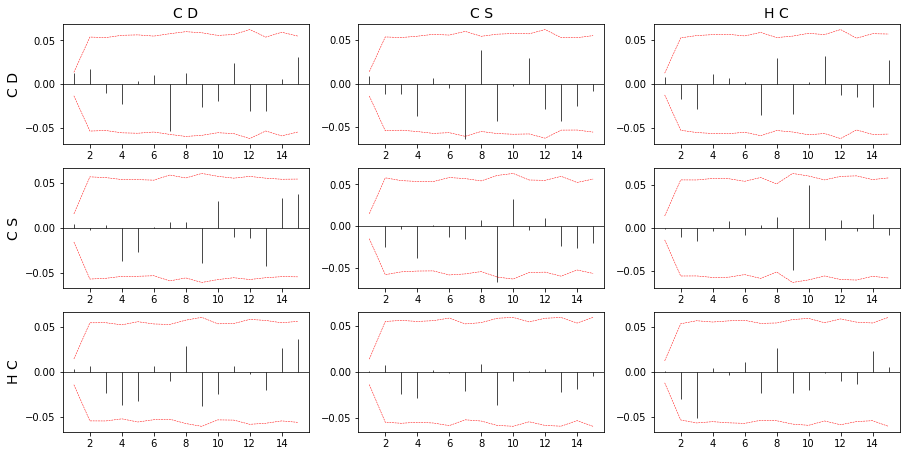

In [14]:
lag=15
port_15=fit.portmanteau_test(15)
se_mix_part=np.sqrt(np.reshape(fit.V_mix_abs[:135]/(T-1-15),(N,15*N),'F'))
se=np.zeros((15,N,N))
for i in range(15):
    se[i]=se_mix_part[:,3*i:3*(i+1)]
T,N=np.shape(eta_ios)
N=3
err_bound = 2 / np.sqrt(T)
xlabel_lags=np.arange(1,lag+1)
fig=plt.figure(num=4,figsize=(15,N*2.5))
k=1
for i in range(N):
    for j in range(N):
        exec(f"ax{k}=fig.add_subplot(33{i*N+j+1})")
        exec(f"ax{k}.vlines(xlabel_lags, [0], eta_MACM[:,i,j] ,color='k',linewidth=0.7)")
        exec(f"ax{k}.plot(xlabel_lags,1.96*se[:,{i},{j}], color='r', linestyle='--',linewidth=0.5)")
        exec(f"ax{k}.plot(xlabel_lags,-1.96*se[:,{i},{j}], color='r', linestyle='--',linewidth=0.5)")
        exec(f"ax{k}.axhline(0, color='k',linewidth=0.7)")


#         exec(f"ax{k}.set_yticks(np.linspace(-0.05,0.05,3))")
        k+=1
# ax1.set_ylabel("ACF")
# exec(f"ax{N+1}.set_ylabel('PACF')")
ax1.set_ylabel("C D",fontsize=14)
ax4.set_ylabel('C S',fontsize=14)
ax7.set_ylabel('H C',fontsize=14)

ax1.set_title("C D",fontsize=14)
ax2.set_title('C S',fontsize=14)
ax3.set_title('H C',fontsize=14)

plt.show()

### MACM plots of absolute residuals<a id="3.5"></a>

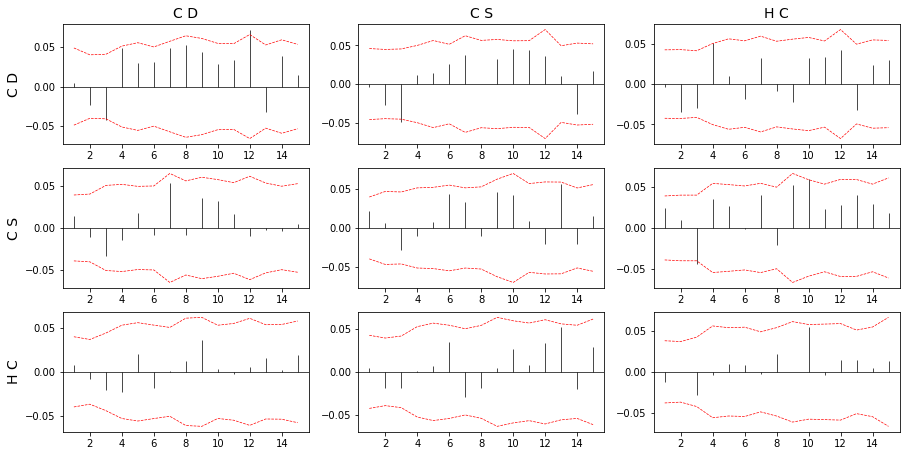

In [15]:
lag=15

T,N=np.shape(eta_ios)
N=3
err_bound = 2 / np.sqrt(T)
xlabel_lags=np.arange(1,lag+1)
fig=plt.figure(num=4,figsize=(15,N*2.5))
k=1
for i in range(N):
    for j in range(N):
        exec(f"ax{k}=fig.add_subplot(33{i*N+j+1})")
        exec(f"ax{k}.vlines(xlabel_lags, [0], eta_abs_MACM[:,i,j] ,color='k',linewidth=0.7)")
        exec(f"ax{k}.axhline(0, color='k',linewidth=0.7)")

        exec(f"ax{k}.plot(xlabel_lags,1.96*se_abs[:,{i},{j}], color='r', linestyle='--',linewidth=0.7)")
        exec(f"ax{k}.plot(xlabel_lags,-1.96*se_abs[:,{i},{j}], color='r', linestyle='--',linewidth=0.7)")
        
        exec(f"ax{k}.set_yticks(np.linspace(-0.05,0.05,3))")
        k+=1
# ax1.set_ylabel("ACF")
# exec(f"ax{N+1}.set_ylabel('PACF')")
ax1.set_ylabel("C D",fontsize=14)
ax4.set_ylabel('C S',fontsize=14)
ax7.set_ylabel('H C',fontsize=14)

ax1.set_title("C D",fontsize=14)
ax2.set_title('C S',fontsize=14)
ax3.set_title('H C',fontsize=14)
plt.savefig('MACF_abs_eta.pdf')
plt.show()

## Recursive forecasting<a id="4"></a>
### prediction functions<a id="4.1"></a>

In [16]:
def predict_LDAR(y_train, y_test, quant, p=1,q=1):
    
    y_train,y_test=np.array(y_train),np.array(y_test) 
    r=max(p,q)
    T_test,N = np.shape(y_test)

    
    
    y_oos = np.zeros((T_test,N)) ##save forecasts
    var_oos=np.zeros((T_test,N,N)) ##save predicted covariance 
    VaR_MV=dict(zip(quant,[np.zeros(T_test),np.zeros(T_test),\
                           np.zeros(T_test),np.zeros(T_test),\
                           np.zeros(T_test),np.zeros(T_test),\
                           np.zeros(T_test),np.zeros(T_test)])) # save VaR
    
    quant_eta= np.zeros((T_test,len(quant)))
    
    port_real_ew=np.zeros(T_test)
    port_real_MV=np.zeros(T_test)

    port_ew=np.zeros(T_test)
    port_MV=np.zeros(T_test)
    
    for t in tqdm(range(T_test)):
        y_all= np.vstack((y_train[0:], y_test[0:t]))
        T=len(y_all)
        h_pre=np.zeros(N)
        
        h_ios=np.zeros((T-r,N))
        epsilon_ios=np.zeros((T-r,N))
        var_ios=np.zeros((T-r,N,N))
        
        for i in range(N):
            y=y_all[:,i].ravel('F')
            model= LDAR(y)
            fitted_lam=model.fit(p,q,max_iter=10,total_tol=1e-3,r_m=0)
            y_predict=model.y_pre()
            y_oos[t,i],h_pre[i],epsilon_ios[:,i],h_ios[:,i]= \
            y_predict[['y_pre','h_pre','epsilon_trim','H_trim']]
        eta_ios=epsilon_ios/h_ios
#         R=np.corrcoef(eta_ios.T)
        R=np.eye(N)
        for i in range(T-r):
            var_ios[i]=np.outer(h_ios[i],h_ios[i])*R
        var_oos[t]=np.outer(h_pre,h_pre)*R
        
        #MV
        var_inv=np.linalg.inv(var_oos[t])
        C_MV=np.ones(N)@var_inv@np.ones(N)
        weight_MV=var_inv@np.ones(N)/C_MV
        port_MV[t]=y_oos[t]@weight_MV
        port_MV_epsilon_ios= epsilon_ios@weight_MV 
        port_MV_var_ios=weight_MV @ var_ios @ weight_MV
        port_MV_eta_ios=port_MV_epsilon_ios/np.sqrt(port_MV_var_ios)
        for k in quant:
            quant_MV=np.percentile(port_MV_eta_ios,k)
            VaR_MV[k][t]=-(port_MV[t]+quant_MV*np.sqrt(weight_MV@var_oos[t]@weight_MV))
        port_real_MV[t]=weight_MV@y_test[t]
        
    create = {"y_oos": y_oos,
             "var_oos":var_oos,
             "port_MV":port_MV,
              "VaR_MV":VaR_MV,
              "port_real_MV":port_real_MV}
    result=pd.Series(create)
    return result

        

In [17]:
def predict_VAR(y_train, y_test, quant,  p=1):

    y_train,y_test=np.array(y_train),np.array(y_test) 


    T_test,N = np.shape(y_test)

    y_oos = np.zeros((T_test,N)) ##save forecasts
    var_oos=np.zeros((T_test,N,N)) ##save predicted covariance 
    VaR_MV=dict(zip(quant,[np.zeros(T_test),np.zeros(T_test),\
                           np.zeros(T_test),np.zeros(T_test),\
                           np.zeros(T_test),np.zeros(T_test),\
                           np.zeros(T_test),np.zeros(T_test)])) # save VaR
    quant_eta= np.zeros((T_test,len(quant)))
    
    port_real_ew=np.zeros(T_test)
    port_real_MV=np.zeros(T_test)

    port_ew=np.zeros(T_test)
    port_MV=np.zeros(T_test)
    
    for t in tqdm(range(T_test)):

        y= np.vstack((y_train[0:], y_test[0:t]))
        T=len(y)
        model_CMean=VAR(y)
        fit_CMean=model_CMean.fit(1)
        res = fit_CMean.resid
        y_oos[t] = fit_CMean.forecast(y[-1:],1)
        epsilon_ios=res

        #MV
        mean_epsilon=np.mean(epsilon_ios,0)
        for i in range(T-1):
            var_oos[t]+=np.outer(epsilon_ios[i]-mean_epsilon,epsilon_ios[i]-mean_epsilon)/(T-1)        
        var_inv=np.linalg.inv(var_oos[t])
        C_MV=np.ones(N)@var_inv@np.ones(N)
        weight_MV=var_inv@np.ones(N)/C_MV
        port_MV[t]=y_oos[t]@weight_MV
        port_MV_epsilon_ios= epsilon_ios@weight_MV 

        for k in quant:
            quant_MV=np.percentile(port_MV_epsilon_ios,k)
            VaR_MV[k][t]=-(port_MV[t]+quant_MV)
        port_real_MV[t]=weight_MV@y_test[t]
        
    create = {"y_oos": y_oos,
             "var_oos":var_oos,
             "port_MV":port_MV,
              "VaR_MV":VaR_MV,
              "port_real_MV":port_real_MV}
    result=pd.Series(create)
    return result

        

In [18]:
def predict_CCCGARCH(y_train, y_test, quant, p=1):

    y_train,y_test=np.array(y_train),np.array(y_test) 


    T_test,N = np.shape(y_test)

    y_oos = np.zeros((T_test,N)) ##save forecasts
    var_oos=np.zeros((T_test,N,N)) ##save predicted covariance 
    VaR_MV=dict(zip(quant,[np.zeros(T_test),np.zeros(T_test),\
                           np.zeros(T_test),np.zeros(T_test),\
                           np.zeros(T_test),np.zeros(T_test),\
                           np.zeros(T_test),np.zeros(T_test)])) # save VaR
    quant_eta= np.zeros((T_test,len(quant)))
    
    port_real_ew=np.zeros(T_test)
    port_real_MV=np.zeros(T_test)

    port_ew=np.zeros(T_test)
    port_MV=np.zeros(T_test)
    
    for t in tqdm(range(T_test)):

        y= np.vstack((y_train[0:], y_test[0:t]))
        T=len(y)
        y_oos[t] = np.mean(y,0)
        res = y-np.mean(y,0)
        model_CVar=mgarch()
        fit_CVar=model_CVar.fit(res)
        D_ios=model_CVar.D_t
        h_hat = model_CVar.predict()
        var_oos[t]=np.outer(h_hat,h_hat)*model_CVar.R
        var_ios=np.zeros((T,N,N))
        for k in range(T):
            var_ios[k]=np.outer(D_ios[k],D_ios[k])*model_CVar.R
        epsilon_ios=res
        
        #MV
        var_inv=np.linalg.inv(var_oos[t])
        C_MV=np.ones(N)@var_inv@np.ones(N)
        weight_MV=var_inv@np.ones(N)/C_MV
        port_MV[t]=y_oos[t]@weight_MV
        port_MV_epsilon_ios= epsilon_ios@weight_MV 
        port_MV_var_ios=weight_MV @ var_ios @ weight_MV
        port_MV_eta_ios=port_MV_epsilon_ios/np.sqrt(port_MV_var_ios)
        for k in quant:
            quant_MV=np.percentile(port_MV_eta_ios,k)
            VaR_MV[k][t]=-(port_MV[t]+quant_MV*np.sqrt(weight_MV@var_oos[t]@weight_MV))
        port_real_MV[t]=weight_MV@y_test[t]
        
    create = {"y_oos": y_oos,
             "var_oos":var_oos,
             "port_MV":port_MV,
              "VaR_MV":VaR_MV,
              "port_real_MV":port_real_MV}
    result=pd.Series(create)
    return result

        

In [19]:
def predict_VARCCCGARCH(y_train, y_test, quant, p=1):
    y_train,y_test=np.array(y_train),np.array(y_test) 


    T_test,N = np.shape(y_test)

    y_oos = np.zeros((T_test,N)) ##save forecasts
    var_oos=np.zeros((T_test,N,N)) ##save predicted covariance 
    VaR_MV=dict(zip(quant,[np.zeros(T_test),np.zeros(T_test),\
                           np.zeros(T_test),np.zeros(T_test),\
                           np.zeros(T_test),np.zeros(T_test),\
                           np.zeros(T_test),np.zeros(T_test)])) # save VaR
    quant_eta= np.zeros((T_test,len(quant)))
    
    port_real_ew=np.zeros(T_test)
    port_real_MV=np.zeros(T_test)

    port_ew=np.zeros(T_test)
    port_MV=np.zeros(T_test)
    
    for t in tqdm(range(T_test)):

        y= np.vstack((y_train[0:], y_test[0:t]))
        T=len(y)
        model_CMean=VAR(y)
        fit_CMean=model_CMean.fit(1)
        res = fit_CMean.resid
        model_CVar=mgarch()
        fit_CVar=model_CVar.fit(res)
        D_ios=model_CVar.D_t
        y_oos[t] = fit_CMean.forecast(y[-1:],1)
        h_hat = model_CVar.predict()
        var_oos[t]=np.outer(h_hat,h_hat)*model_CVar.R
        var_ios=np.zeros((T-p,N,N))
        for k in range(T-p):
            var_ios[k]=np.outer(D_ios[k],D_ios[k])*model_CVar.R
        epsilon_ios=res
        

        #MV
        var_inv=np.linalg.inv(var_oos[t])
        C_MV=np.ones(N)@var_inv@np.ones(N)
        weight_MV=var_inv@np.ones(N)/C_MV
        port_MV[t]=y_oos[t]@weight_MV
        port_MV_epsilon_ios= epsilon_ios@weight_MV 
        port_MV_var_ios=weight_MV @ var_ios @ weight_MV
        port_MV_eta_ios=port_MV_epsilon_ios/np.sqrt(port_MV_var_ios)
        for k in quant:
            quant_MV=np.percentile(port_MV_eta_ios,k)
            VaR_MV[k][t]=-(port_MV[t]+quant_MV*np.sqrt(weight_MV@var_oos[t]@weight_MV))
        port_real_MV[t]=weight_MV@y_test[t]
        
    create = {"y_oos": y_oos,
             "var_oos":var_oos,
             "port_MV":port_MV,
              "VaR_MV":VaR_MV,
              "port_real_MV":port_real_MV}
    result=pd.Series(create)
    return result

        

In [20]:
def predict_VLDAR(y_train, y_test, qunat, p=1,q=1):

    y_train,y_test=np.array(y_train),np.array(y_test) 
    r=max(p,q)

    T_test,N = np.shape(y_test)

    y_oos = np.zeros((T_test,N)) ##save forecasts
    var_oos=np.zeros((T_test,N,N)) ##save predicted covariance 
    VaR_MV=dict(zip(quant,[np.zeros(T_test),np.zeros(T_test),\
                           np.zeros(T_test),np.zeros(T_test),\
                           np.zeros(T_test),np.zeros(T_test),\
                           np.zeros(T_test),np.zeros(T_test)])) # save VaR
    quant_eta= np.zeros((T_test,len(quant)))
    
    port_real_ew=np.zeros(T_test)
    port_real_MV=np.zeros(T_test)

    port_ew=np.zeros(T_test)
    port_MV=np.zeros(T_test)
    
    for t in tqdm(range(T_test)):

        y= np.vstack((y_train[0:], y_test[0:t]))
        
        T=len(y)
        model=SQMLE_VLDAR_BCD(y)
        fitted_lam=model.fit(p,q,step_select=3,max_iter=10,max_iter_var=4,var_tol=1e-2,total_tol=1e-2,r_m=0)
        y_predict=model.y_pre()
        y_oos[t],var_oos[t],epsilon_ios,var_ios = y_predict[['y_pre','var_pre','epsilon_ios','var_ios']]
        

        #MV
        var_inv=np.linalg.inv(var_oos[t])
        C_MV=np.ones(N)@var_inv@np.ones(N)
        weight_MV=var_inv@np.ones(N)/C_MV
        port_MV[t]=y_oos[t]@weight_MV
        port_MV_epsilon_ios= epsilon_ios@weight_MV 
        port_MV_var_ios=weight_MV @ var_ios @ weight_MV
        port_MV_eta_ios=port_MV_epsilon_ios/np.sqrt(port_MV_var_ios)
        for k in quant:
            quant_MV=np.percentile(port_MV_eta_ios,k)
            VaR_MV[k][t]=-(port_MV[t]+quant_MV*np.sqrt(weight_MV@var_oos[t]@weight_MV))
        port_real_MV[t]=weight_MV@y_test[t]
        
    create = {"y_oos": y_oos,
             "var_oos":var_oos,
             "port_MV":port_MV,
              "VaR_MV":VaR_MV,
              "port_real_MV":port_real_MV}
    result=pd.Series(create)
    return result

In [21]:
def VaRbacktest(Hit,VaR,tau,p):
    """
    Input:
    --------------------------
    Hit: I(z_t<Q_tau(z_t|F_{t-1}))
    VaR: negative tau quantile of portfolio z_t
    tau:tau quantile
    p:the lag order in DQ test
    --------------------------
    Output:
    backtesting indices
    
    """
    n=len(Hit);n1=sum(Hit)
    tauhat=n1/n
    ### Uncond coverage test
    likUC_null = tau**n1*(1-tau)**(n-n1)
    likUC_alt = tauhat**n1*(1-tauhat)**(n-n1)
    LR_UC = -2*np.log(likUC_null/likUC_alt)
    P_UC = 1-stats.chi2.cdf(LR_UC, 1)
    ### Independence test

    ContTable = pd.crosstab(Hit[0:n-1], Hit[1:n])
    n00 = ContTable.iloc[0, 0]
    n01 = ContTable.iloc[0, 1]
    n10 = ContTable.iloc[1, 0]
    n11 = ContTable.iloc[1, 1]
    tau_null = (n01+n11)/(n00+n01+n10+n11)
    tau0_alt = n01/(n00+n01); tau1_alt= n11/(n10+n11)
    likInd_null = tau_null**(n01+n11)*(1-tau_null)**(n00+n10)
    likInd_alt = tau0_alt**n01*(1-tau0_alt)**n00 * \
        tau1_alt**n11*(1-tau1_alt)**n10
    LR_Ind = -2*np.log(likInd_null/likInd_alt)
    P_Ind = 1-stats.chi2.cdf(LR_Ind, 1)


    ### Cond coverage test
    LR_CC = LR_UC+LR_Ind
    P_CC = 1-stats.chi2.cdf(LR_CC, 2)

    ###PE
    EP=np.abs( (n1/n-tau)/np.sqrt(tau*(1-tau)/n) )
    ### DQ test 1: hits only
    X_Hit_only=np.ones((1,n-p))
    for i in range(p):
        X_Hit_only=np.vstack((X_Hit_only,Hit[p-i-1:-i-1]))
    
    X=X_Hit_only.T
    if np.linalg.det(X.T@X) <= 10**(-5):
        P_DQ1 = None
    else:
        DQ1 = (Hit[p:n]-tau).T@X@np.linalg.inv(X.T @X)@X.T@(Hit[p:n]-tau)/tau/(1-tau)
        P_DQ1 = 1-stats.chi2.cdf(DQ1, p+1)
    X_all=np.vstack((X_Hit_only,VaR[p:n]))
    X=X_all.T
    if np.linalg.det(X.T@X) <= 10**(-5):
        P_DQ2 = None
    else:
        DQ2 = (Hit[p:n]-tau).T@X@np.linalg.inv(X.T @X)@X.T@(Hit[p:n]-tau)/tau/(1-tau)
        P_DQ2 = 1-stats.chi2.cdf(DQ1, p+2)
    ECR = np.mean(Hit)
    result = {"ECR": ECR,
              "UC": P_UC,
              "Ind": P_Ind,
              "CC": P_CC,
              "DQ_hist": P_DQ1,
              "DQ_comb": P_DQ2,
             "EP":EP}
    result = pd.Series(result)
    return result
                                                                          
                                                                          

### Forecasts<a id="4.2"></a>

In [22]:
y_train=yt[:522]
y_test=yt[522:]
quant=[1,5,95,99]

In [23]:
pre_LDAR=predict_LDAR(y_train, y_test, quant, p=1,q=3)
pre_VARCCCGARCH=predict_VARCCCGARCH(y_train, y_test, quant, p=1)
pre_VLDAR=predict_VLDAR(y_train, y_test, quant, p=1,q=3)
pre_VAR=predict_VAR(y_train, y_test, quant, p=1)
pre_CCCGARCH=predict_CCCGARCH(y_train, y_test, quant, p=1)


100%|████████████████████████████████████████████████████████████████████████████████| 732/732 [02:18<00:00,  5.27it/s]


In [27]:
quant=[1,5,95,99]
index_list=['ECR','UC','Ind','CC','DQ_hist','DQ_comb','EP']
method_list=['VLDAR','VAR','CCCGARCH','VARCCCGARCH','LDAR']

for i in tqdm(method_list):
    exec(f"test_{i}=pd.DataFrame(index=index_list)")
    for k in quant:
        tau = k/100
        exec(f"VaR_MV = pre_{i}['VaR_MV'][{k}]")
        exec(f"Hit_MV= (pre_{i}['port_real_MV'] < (-VaR_MV))")
        exec(f"test_{i}[{k}]=VaRbacktest(Hit_MV,VaR_MV,tau,p=4).round(4)")



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.95it/s]


In [28]:
statistics=['ECR','EP','CC','DQ_comb']

result_VaR=pd.DataFrame(np.zeros((len(method_list),len(statistics)*len(quant) )),
            index=method_list,
            columns=pd.MultiIndex.from_product([quant,statistics]))
for i in method_list:
    for k in quant:
        for l in statistics:
            exec(f"result_VaR[{k}]['{l}']['{i}']=test_{i}[{k}]['{l}']")


<ipython-input-28-fe5b64907b13>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(f"result_VaR[{k}]['{l}']['{i}']=test_{i}[{k}]['{l}']")


### Backtests <a id="4.3"></a>

In [29]:
result_VaR.round(4)

1                               5                           \
                ECR      EP      CC DQ_comb     ECR      EP      CC DQ_comb   
VLDAR        0.0137  0.9955  0.5580  0.9344  0.0492  0.1018  0.3058  0.6567   
VAR          0.0096  0.1189  0.1482  0.0000  0.0478  0.2713  0.0796  0.0212   
CCCGARCH     0.0150  1.3670  0.3762  0.8088  0.0533  0.4070  0.1671  0.2715   
VARCCCGARCH  0.0123  0.6241  0.7455  0.1373  0.0546  0.5766  0.1825  0.3150   
LDAR         0.0150  1.3670  0.1588  0.1589  0.0587  1.0854  0.3763  0.8385   

                 95                              99                          
                ECR      EP      CC DQ_comb     ECR      EP      CC DQ_comb  
VLDAR        0.9454  0.5766  0.0890  0.3505  0.9863  0.9955  0.5658  0.9851  
VAR          0.9481  0.2374  0.3653  0.0699  0.9918  0.4903  0.0954  0.0000  
CCCGARCH     0.9467  0.4070  0.1084  0.3430  0.9809  2.4814  0.0684  0.3819  
VARCCCGARCH  0.9331  2.1029  0.0421  0.0432  0.9822  2.1100  0.1319  0.6049  
LDAR         0.9413  1.0854  0.3072  0.1438  0.9795  2.8529  0.0329  0.0811